In [11]:
import torch
import numpy as np

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_90445/2332691625.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')


In [13]:
p_beta = torch.load("../data/models/p_beta.pt")
p_beta.eval();

In [14]:
beta_samples = p_beta.sample(num_samples=100).detach().numpy()
beta_samples.shape

(100, 4)

In [15]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")[:, :-3]
fit_betas = np.load("../data/fit_betas_P+B_new.npy").T

# remove b3 and bk2 (index 2 and 5) from betas
fit_betas = fit_betas[:, [0, 1, 3, 4]]

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 7), (10500, 4))

In [16]:
# Set random seed in numpy and torch
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [17]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 4]),
 torch.Size([9975, 7]),
 torch.Size([525, 4]),
 torch.Size([525, 7]))

In [18]:
from tqdm import tqdm

def simulation_based_calibration(validation_samples, flow, num_posterior_samples=100):
    ranks = []
    
    for original_sample in tqdm(validation_samples):
        
        # Generate samples from the normalizing flow
        flow_samples = flow.sample(num_samples=num_posterior_samples).detach().numpy()
        
        # Calculate the rank of the original sample among the flow samples
        rank = sum(flow_samples < original_sample.detach().numpy())
        ranks.append(rank)
    
    return ranks

In [19]:
num_posterior_samples = 100
ranks = simulation_based_calibration(X_val, p_beta, num_posterior_samples=num_posterior_samples)

100%|██████████| 525/525 [00:03<00:00, 160.91it/s]


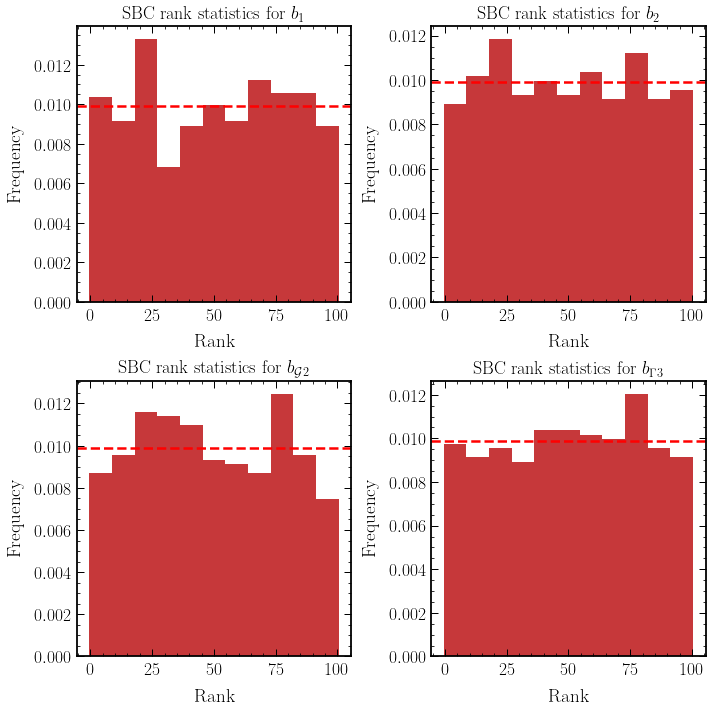

In [20]:
# Make a plot showing rank for all 4 parameters in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

num_bins = 10

param_names = [r'$b_1$', r'$b_2$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$',]

for i in range(4):
    ax = axs[i//2, i%2]
    ax.hist(np.array(ranks)[:, i], bins=num_bins+1, range=(-0.5, num_posterior_samples+0.5), density=True)
    ax.axhline(y=1/(num_posterior_samples+1), color='r', linestyle='--')  # Expected uniform density
    ax.set_xlabel('Rank')
    ax.set_ylabel('Frequency')
    ax.set_title(f"SBC rank statistics for {param_names[i]}")

plt.tight_layout()
# plt.savefig("figures/ranks.pdf")

In [21]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")[:, :-3]
fit_betas = np.load("../data/fit_betas_P+B_new.npy").T

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 7), (10500, 8))

In [22]:
# Set random seed in numpy and torch
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [23]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 8]),
 torch.Size([9975, 7]),
 torch.Size([525, 8]),
 torch.Size([525, 7]))

In [24]:
p_beta_hod = torch.load("../data/models/p_beta_hod.pt")
p_beta_hod.eval();

In [63]:
from tqdm import tqdm

def simulation_based_calibration(X_val, Y_val, flow, num_posterior_samples=100):
    ranks = []
    
    for i in tqdm(range(len(X_val))):

        sample, context = X_val[i], Y_val[i] 

        # # Repeat context along first axis num_posterior_samples times
        # context = context.repeat(num_posterior_samples, 1)
        
        # Generate samples from the normalizing flow
        flow_samples = flow.sample(num_samples=num_posterior_samples, context=context[None, ...]).detach().numpy()[0, ...]
        
        # Calculate the rank of the original sample among the flow samples
        rank = sum(flow_samples < sample.detach().numpy())
        ranks.append(rank)
    
    return ranks

In [64]:
num_posterior_samples = 100
ranks = simulation_based_calibration(X_val, Y_val, p_beta_hod, num_posterior_samples=num_posterior_samples)

  1%|          | 6/525 [00:00<00:18, 27.96it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  2%|▏         | 9/525 [00:00<00:19, 26.90it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  3%|▎         | 15/525 [00:00<00:19, 26.47it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  4%|▍         | 21/525 [00:00<00:18, 26.68it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  5%|▌         | 27/525 [00:01<00:19, 25.73it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  6%|▋         | 33/525 [00:01<00:18, 26.79it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  7%|▋         | 39/525 [00:01<00:19, 25.17it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


  9%|▊         | 45/525 [00:01<00:17, 26.97it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 10%|▉         | 51/525 [00:01<00:16, 28.07it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 11%|█         | 57/525 [00:02<00:16, 28.32it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 12%|█▏        | 63/525 [00:02<00:16, 27.92it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 13%|█▎        | 69/525 [00:02<00:16, 28.42it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 14%|█▍        | 75/525 [00:02<00:16, 28.07it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 15%|█▌        | 81/525 [00:03<00:17, 25.32it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 17%|█▋        | 87/525 [00:03<00:17, 25.55it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 18%|█▊        | 93/525 [00:03<00:16, 26.41it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 19%|█▉        | 99/525 [00:03<00:15, 26.99it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 20%|██        | 105/525 [00:03<00:15, 26.68it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 21%|██        | 108/525 [00:04<00:16, 25.48it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 22%|██▏       | 114/525 [00:04<00:18, 22.21it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 23%|██▎       | 120/525 [00:04<00:16, 24.44it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 24%|██▍       | 126/525 [00:04<00:15, 25.95it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 25%|██▌       | 132/525 [00:05<00:14, 26.63it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 26%|██▋       | 138/525 [00:05<00:14, 27.24it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 27%|██▋       | 144/525 [00:05<00:13, 28.04it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 29%|██▉       | 151/525 [00:05<00:12, 29.13it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 29%|██▉       | 154/525 [00:05<00:14, 25.40it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 30%|███       | 160/525 [00:06<00:13, 26.63it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 32%|███▏      | 168/525 [00:06<00:12, 28.95it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 34%|███▎      | 176/525 [00:06<00:11, 29.96it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 34%|███▍      | 180/525 [00:06<00:11, 30.47it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 36%|███▌      | 188/525 [00:06<00:11, 30.38it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 37%|███▋      | 195/525 [00:07<00:11, 29.59it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 38%|███▊      | 198/525 [00:07<00:12, 27.14it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 39%|███▉      | 206/525 [00:07<00:11, 28.61it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 40%|████      | 212/525 [00:07<00:11, 27.86it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 41%|████      | 215/525 [00:07<00:12, 25.42it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 42%|████▏     | 221/525 [00:08<00:14, 20.27it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 43%|████▎     | 224/525 [00:08<00:15, 19.46it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 44%|████▍     | 230/525 [00:08<00:15, 19.59it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 44%|████▍     | 233/525 [00:08<00:14, 20.22it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 46%|████▌     | 239/525 [00:09<00:13, 21.92it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 47%|████▋     | 245/525 [00:09<00:11, 23.71it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 47%|████▋     | 248/525 [00:09<00:11, 24.58it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 48%|████▊     | 254/525 [00:10<00:16, 16.93it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 50%|████▉     | 260/525 [00:10<00:13, 19.80it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 50%|█████     | 263/525 [00:10<00:12, 21.09it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 51%|█████     | 269/525 [00:10<00:12, 19.86it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 52%|█████▏    | 272/525 [00:10<00:12, 19.63it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 53%|█████▎    | 278/525 [00:11<00:11, 21.72it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 54%|█████▍    | 284/525 [00:11<00:11, 20.83it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 55%|█████▍    | 287/525 [00:11<00:11, 19.97it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 56%|█████▌    | 293/525 [00:11<00:10, 21.11it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 56%|█████▋    | 296/525 [00:12<00:13, 17.21it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 57%|█████▋    | 301/525 [00:12<00:12, 17.93it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 58%|█████▊    | 304/525 [00:12<00:11, 19.12it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 59%|█████▉    | 309/525 [00:12<00:10, 19.89it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 60%|██████    | 315/525 [00:13<00:09, 22.54it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 61%|██████    | 318/525 [00:13<00:10, 19.54it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 62%|██████▏   | 324/525 [00:13<00:10, 19.93it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 62%|██████▏   | 327/525 [00:13<00:10, 19.12it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 63%|██████▎   | 331/525 [00:14<00:11, 17.04it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 63%|██████▎   | 333/525 [00:14<00:11, 16.10it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 65%|██████▍   | 339/525 [00:14<00:09, 19.27it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 65%|██████▌   | 343/525 [00:14<00:10, 16.78it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 66%|██████▌   | 345/525 [00:14<00:11, 15.89it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 66%|██████▋   | 349/525 [00:15<00:11, 15.20it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 67%|██████▋   | 353/525 [00:15<00:11, 14.97it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 68%|██████▊   | 358/525 [00:15<00:09, 17.65it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 69%|██████▉   | 364/525 [00:15<00:07, 20.89it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 70%|██████▉   | 367/525 [00:15<00:07, 21.70it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 71%|███████   | 373/525 [00:16<00:07, 21.70it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 72%|███████▏  | 376/525 [00:16<00:07, 21.28it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 73%|███████▎  | 382/525 [00:16<00:06, 21.99it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 73%|███████▎  | 385/525 [00:16<00:06, 22.64it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 74%|███████▍  | 391/525 [00:17<00:06, 21.45it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 76%|███████▌  | 397/525 [00:17<00:05, 22.30it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 76%|███████▌  | 400/525 [00:17<00:05, 22.35it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 77%|███████▋  | 406/525 [00:17<00:05, 23.32it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 78%|███████▊  | 412/525 [00:17<00:04, 23.55it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 79%|███████▉  | 415/525 [00:18<00:04, 23.62it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 80%|████████  | 421/525 [00:18<00:04, 22.22it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 81%|████████▏ | 427/525 [00:18<00:04, 23.39it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 82%|████████▏ | 433/525 [00:18<00:03, 24.39it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 83%|████████▎ | 436/525 [00:19<00:03, 23.98it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 84%|████████▍ | 442/525 [00:19<00:03, 24.17it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 85%|████████▌ | 448/525 [00:19<00:03, 24.12it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 86%|████████▌ | 451/525 [00:19<00:03, 24.11it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 87%|████████▋ | 457/525 [00:19<00:03, 20.91it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 88%|████████▊ | 463/525 [00:20<00:02, 22.96it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 89%|████████▉ | 469/525 [00:20<00:02, 24.51it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 90%|█████████ | 475/525 [00:20<00:01, 25.04it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 91%|█████████ | 478/525 [00:20<00:01, 24.53it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 92%|█████████▏| 484/525 [00:21<00:01, 23.00it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 93%|█████████▎| 490/525 [00:21<00:01, 24.08it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 94%|█████████▍| 496/525 [00:21<00:01, 23.39it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 95%|█████████▌| 499/525 [00:21<00:01, 23.68it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 96%|█████████▌| 505/525 [00:21<00:00, 23.30it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 97%|█████████▋| 511/525 [00:22<00:00, 23.45it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 98%|█████████▊| 514/525 [00:22<00:00, 23.37it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


 99%|█████████▉| 520/525 [00:22<00:00, 23.48it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


100%|██████████| 525/525 [00:22<00:00, 23.03it/s]

(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])
(100, 8) torch.Size([8]) torch.Size([7])


In [65]:
ranks

[array([26, 80, 12, 85, 11, 64, 48, 57]),
 array([33, 74, 36, 84, 40, 37, 54, 33]),
 array([71, 88, 69, 44, 55, 64, 52, 94]),
 array([71, 79, 64,  9, 88, 59, 80, 20]),
 array([88, 99, 92, 22, 70, 69, 82, 59]),
 array([65, 73, 73, 31, 66, 36, 63, 61]),
 array([99, 97, 93, 10, 94, 46, 30, 89]),
 array([57, 82, 77, 15, 66, 56, 27, 52]),
 array([100, 100,  95,   0, 100,  17,  95, 100]),
 array([60, 79, 56, 59, 19, 43, 46, 52]),
 array([22, 26, 72, 73,  9, 20, 70, 39]),
 array([40, 54, 91, 54, 33, 34, 46, 90]),
 array([93, 93, 94,  0, 98, 13, 58, 75]),
 array([86, 90, 85,  3, 99, 69, 47, 97]),
 array([76, 90, 87,  4, 87, 55, 58, 74]),
 array([50, 82, 78, 26, 42,  3, 88, 50]),
 array([49, 84, 17, 53, 36, 14, 27, 84]),
 array([52, 82, 95, 37, 55, 45, 17, 45]),
 array([40, 87, 70, 24, 70, 61, 42, 27]),
 array([94, 98, 87,  2, 92,  2, 23, 82]),
 array([62, 86, 95,  7, 53,  3, 26, 57]),
 array([37, 92, 96, 41, 18, 43, 20, 99]),
 array([98, 96, 95,  3, 97,  2, 99, 98]),
 array([21, 30, 38, 81, 19

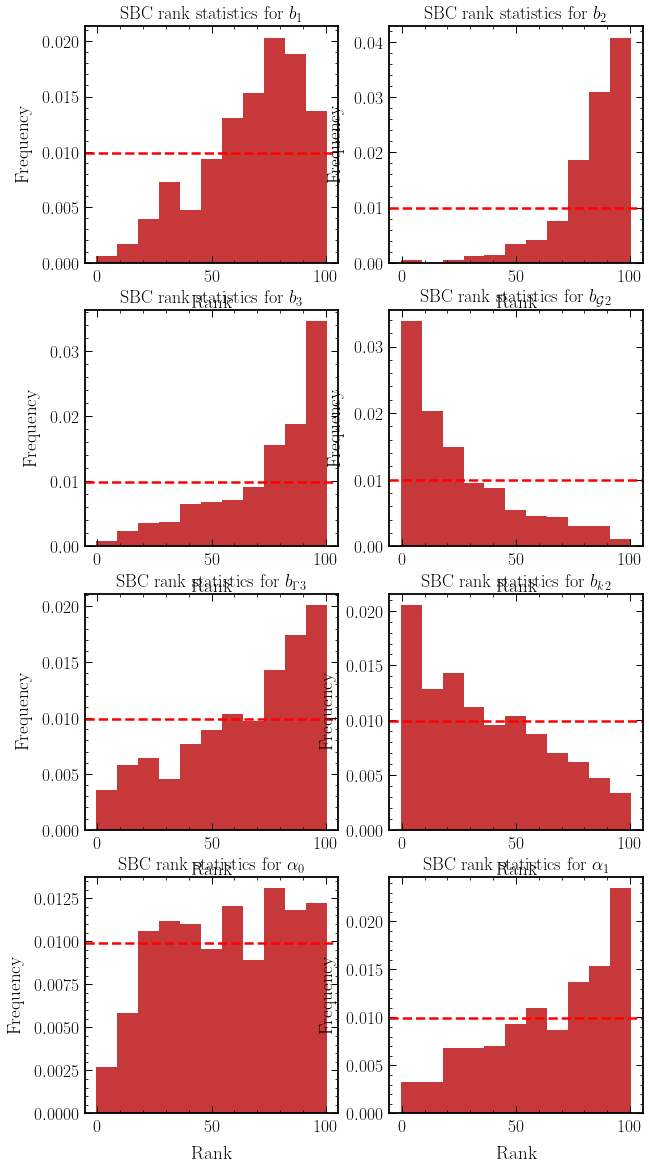

In [66]:
param_names = [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$', r"$\alpha_0$", r"$\alpha_1$",]

# Make a plot showing rank for all 8 parameters in 2x4 grid

fig, axs = plt.subplots(4, 2, figsize=(10, 20))

num_bins = 10

for i in range(8):
    ax = axs[i//2, i%2]
    ax.hist(np.array(ranks)[:, i], bins=num_bins+1, range=(-0.5, num_posterior_samples+0.5), density=True)
    ax.axhline(y=1/(num_posterior_samples+1), color='r', linestyle='--')  # Expected uniform density
    ax.set_xlabel('Rank')
    ax.set_ylabel('Frequency')
    ax.set_title(f"SBC rank statistics for {param_names[i]}")